In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder("../../data", transform=transform)

keep_classes = ["Forest", "Residential"]
keep_indices = [i for i, (_, label) in enumerate(full_dataset) if full_dataset.classes[label] in keep_classes]
subset = Subset(full_dataset, keep_indices)

class_map = {
    full_dataset.class_to_idx["Forest"]: 0,
    full_dataset.class_to_idx["Residential"]: 1
}

class RelabeledDataset(Dataset):
    def __init__(self, subset, class_map):
        self.subset = subset
        self.class_map = class_map
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.class_map[y]

dataset = RelabeledDataset(subset, class_map)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [5]:
print(len(train_ds), len(val_ds))
print(full_dataset.classes)

import torch

all_labels = [y for _, y in dataset]
unique_labels = torch.unique(torch.tensor(all_labels))
print("Labels présents dans le dataset :", unique_labels.tolist())



4800 1200
['Forest', 'OOD', 'Residential']
Labels présents dans le dataset : [0, 1]


In [6]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, history


In [8]:
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=10)

Epoch [1/30] | Train Loss: 0.1209 | Val Loss: 0.0045 | Val Acc: 0.9992
Epoch [2/30] | Train Loss: 0.0068 | Val Loss: 0.0022 | Val Acc: 0.9992
Epoch [3/30] | Train Loss: 0.0062 | Val Loss: 0.0047 | Val Acc: 0.9983
Epoch [4/30] | Train Loss: 0.0118 | Val Loss: 0.0050 | Val Acc: 0.9983
Epoch [5/30] | Train Loss: 0.0050 | Val Loss: 0.0017 | Val Acc: 1.0000
Epoch [6/30] | Train Loss: 0.0037 | Val Loss: 0.0038 | Val Acc: 0.9983
Epoch [7/30] | Train Loss: 0.0058 | Val Loss: 0.0018 | Val Acc: 0.9992
Epoch [8/30] | Train Loss: 0.0016 | Val Loss: 0.0028 | Val Acc: 0.9992
Epoch [9/30] | Train Loss: 0.0063 | Val Loss: 0.0016 | Val Acc: 0.9992
Epoch [10/30] | Train Loss: 0.0021 | Val Loss: 0.0042 | Val Acc: 0.9983
Epoch [11/30] | Train Loss: 0.0029 | Val Loss: 0.0141 | Val Acc: 0.9950
Epoch [12/30] | Train Loss: 0.0034 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [13/30] | Train Loss: 0.0016 | Val Loss: 0.0019 | Val Acc: 0.9983
Epoch [14/30] | Train Loss: 0.0021 | Val Loss: 0.0010 | Val Acc: 0.9992
E

In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
import torch

ood_base = ImageFolder("../../data/OOD", transform=transform)
orig_to_new = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1,
}

class RelabeledDataset(Dataset):
    def __init__(self, base, mapping):
        self.base = base
        self.mapping = mapping
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, self.mapping[y]

rel_ood = RelabeledDataset(ood_base, orig_to_new)

idx_dense  = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["DenseResidential"]]
idx_medium = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["MediumResidential"]]
idx_forest = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["Forest"]]

ood_loader     = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader   = DataLoader(Subset(rel_ood, idx_dense),  batch_size=64, shuffle=False)
medium_loader  = DataLoader(Subset(rel_ood, idx_medium), batch_size=64, shuffle=False)
forest_loader  = DataLoader(Subset(rel_ood, idx_forest), batch_size=64, shuffle=False)

len(ood_base), len(idx_forest), len(idx_dense), len(idx_medium)


(120, 60, 30, 30)

In [10]:
def evaluate(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2,2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t,p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

In [11]:
acc_all, cm_all       = evaluate(model, ood_loader)
acc_forest, cm_forest = evaluate(model, forest_loader)
acc_dense, cm_dense   = evaluate(model, dense_loader)
acc_medium, cm_medium = evaluate(model, medium_loader)

print("OOD global acc:", round(acc_all,4))
print("Forest acc:", round(acc_forest,4))
print("DenseResidential acc:", round(acc_dense,4))
print("MediumResidential acc:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD global acc: 0.7083
Forest acc: 0.4333
DenseResidential acc: 1.0
MediumResidential acc: 0.9667
CM OOD:
 [[26 34]
 [ 1 59]]
CM Forest:
 [[26 34]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 1 29]]


In [12]:
class MTL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.cls_head = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(128, 2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Tanh()
        )
    def forward(self, x):
        z = self.shared(x)
        logits = self.cls_head(z)
        recon = self.dec_head(z)
        return logits, recon


In [13]:
def train_mtl(model, train_loader, val_loader, optimizer, num_epochs=30, alpha=0.5, patience=5):
    ce_loss = nn.CrossEntropyLoss()
    recon_loss = nn.MSELoss()
    best_val = float("inf")
    patience_ctr = 0
    hist = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, recon = model(imgs)
            loss_c = ce_loss(logits, labels)
            loss_r = recon_loss(recon, imgs)
            loss = alpha * loss_c + (1 - alpha) * loss_r
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        tot = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits, recon = model(imgs)
                loss_c = ce_loss(logits, labels)
                loss_r = recon_loss(recon, imgs)
                loss = alpha * loss_c + (1 - alpha) * loss_r
                val_loss += loss.item()
                pred = logits.argmax(1)
                correct += (pred == labels).sum().item()
                tot += labels.size(0)
        val_loss /= len(val_loader)
        val_acc = correct / tot

        hist.append((train_loss, val_loss, val_acc))
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            patience_ctr = 0
            best_w = model.state_dict()
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_w)
    return model, hist

In [14]:
model_mtl = MTL_CNN().to(device)
optimizer = optim.Adam(model_mtl.parameters(), lr=1e-3)

model_mtl, hist_mtl = train_mtl(model_mtl, train_loader, val_loader, optimizer, num_epochs=30, alpha=0.6, patience=10)

Epoch [1/30] | Train Loss: 0.0357 | Val Loss: 0.0825 | Val Acc: 0.9642
Epoch [2/30] | Train Loss: 0.0212 | Val Loss: 0.0079 | Val Acc: 0.9992
Epoch [3/30] | Train Loss: 0.0122 | Val Loss: 0.0086 | Val Acc: 0.9992
Epoch [4/30] | Train Loss: 0.0099 | Val Loss: 0.0064 | Val Acc: 0.9992
Epoch [5/30] | Train Loss: 0.0089 | Val Loss: 0.0038 | Val Acc: 1.0000
Epoch [6/30] | Train Loss: 0.0064 | Val Loss: 0.1791 | Val Acc: 0.9208
Epoch [7/30] | Train Loss: 0.0108 | Val Loss: 0.0034 | Val Acc: 1.0000
Epoch [8/30] | Train Loss: 0.0086 | Val Loss: 0.0030 | Val Acc: 1.0000
Epoch [9/30] | Train Loss: 0.0080 | Val Loss: 0.0031 | Val Acc: 1.0000
Epoch [10/30] | Train Loss: 0.0065 | Val Loss: 0.0028 | Val Acc: 1.0000
Epoch [11/30] | Train Loss: 0.0043 | Val Loss: 0.0034 | Val Acc: 1.0000
Epoch [12/30] | Train Loss: 0.0047 | Val Loss: 0.0022 | Val Acc: 1.0000
Epoch [13/30] | Train Loss: 0.0068 | Val Loss: 0.0023 | Val Acc: 1.0000
Epoch [14/30] | Train Loss: 0.0044 | Val Loss: 0.0021 | Val Acc: 1.0000
E

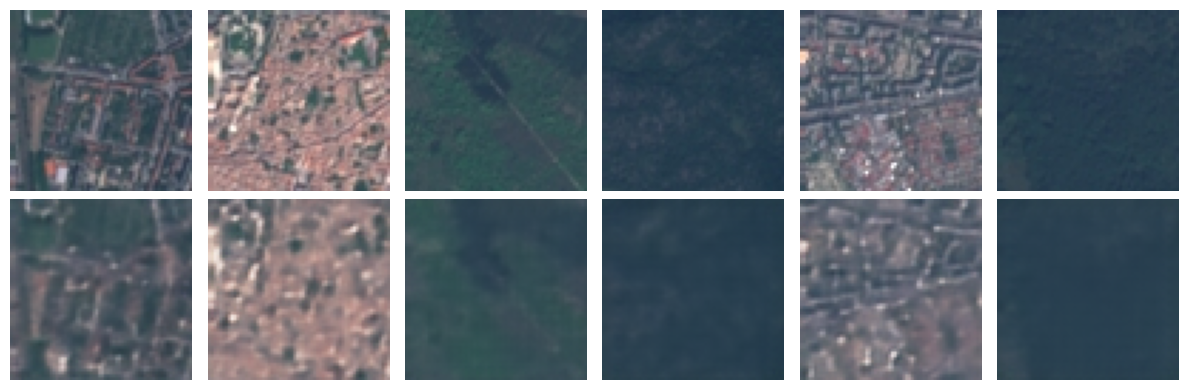

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_reconstructions(model, loader, n=6):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        _, recon = model(imgs)

    imgs = imgs.cpu().permute(0, 2, 3, 1)
    recon = recon.cpu().permute(0, 2, 3, 1)

    imgs = (imgs * 0.5 + 0.5).clamp(0,1)
    recon = (recon * 0.5 + 0.5).clamp(0,1)

    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=12)

        plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Reconstruit", fontsize=12)
    plt.tight_layout()
    plt.show()

show_reconstructions(model_mtl, val_loader)


In [16]:
def evaluate_mtl(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2, 2, dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits, _ = model(x)  
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t, p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

acc_all, cm_all       = evaluate_mtl(model_mtl, ood_loader)
acc_forest, cm_forest = evaluate_mtl(model_mtl, forest_loader)
acc_dense, cm_dense   = evaluate_mtl(model_mtl, dense_loader)
acc_medium, cm_medium = evaluate_mtl(model_mtl, medium_loader)

print("OOD global acc:", round(acc_all,4))
print("Forest acc:", round(acc_forest,4))
print("DenseResidential acc:", round(acc_dense,4))
print("MediumResidential acc:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD global acc: 0.7167
Forest acc: 0.5167
DenseResidential acc: 1.0
MediumResidential acc: 0.8333
CM OOD:
 [[31 29]
 [ 5 55]]
CM Forest:
 [[31 29]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 5 25]]


In [19]:
import torch.nn.functional as F

class SoftShareMTL(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_cls = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )
        self.encoder_rec = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(128, 2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Tanh()
        )
    def forward(self, x):
        zc = self.encoder_cls(x)
        zr = self.encoder_rec(x)
        logits = self.cls_head(zc)
        recon = self.dec_head(zr)
        zc_vec = torch.flatten(F.adaptive_avg_pool2d(zc, 1), 1)
        zr_vec = torch.flatten(F.adaptive_avg_pool2d(zr, 1), 1)
        return logits, recon, zc_vec, zr_vec

def train_soft_share(model, train_loader, val_loader, optimizer, num_epochs=30, alpha=0.9, beta=0.09, gamma=0.01, mask_ratio=0.65, patience=10):
    ce = nn.CrossEntropyLoss()
    best_val = float("inf")
    bad = 0
    for epoch in range(num_epochs):
        model.train()
        tr = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
            xm = x*(1-m)
            optimizer.zero_grad()
            logits, recon, zc, zr = model(xm)
            lc = ce(logits, y)
            l1 = torch.abs(recon - x)*m
            lr = l1.sum()/(m.sum()*x.size(1) + 1e-6)
            la = F.mse_loss(zc, zr)
            loss = alpha*lc + beta*lr + gamma*la
            loss.backward()
            optimizer.step()
            tr += loss.item()
        tr /= len(train_loader)
        model.eval()
        vl, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
                xm = x*(1-m)
                logits, recon, zc, zr = model(xm)
                lc = ce(logits, y)
                l1 = torch.abs(recon - x)*m
                lr = l1.sum()/(m.sum()*x.size(1) + 1e-6)
                la = F.mse_loss(zc, zr)
                loss = alpha*lc + beta*lr + gamma*la
                vl += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        vl /= len(val_loader)
        acc = ok/tot
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {tr:.4f} | Val Loss: {vl:.4f} | Val Acc: {acc:.4f}")

        if vl < best_val:
            best_val = vl
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                break
    model.load_state_dict(best_w)
    return model


In [20]:
model_soft = SoftShareMTL().to(device)
opt_soft = optim.Adam(model_soft.parameters(), lr=1e-3)
model_soft = train_soft_share(model_soft, train_loader, val_loader, opt_soft, num_epochs=30, alpha=0.9, beta=0.09, gamma=0.01, mask_ratio=0.65, patience=10)

Epoch [1/30] | Train Loss: 0.0739 | Val Loss: 0.1026 | Val Acc: 0.9667
Epoch [2/30] | Train Loss: 0.0555 | Val Loss: 0.0384 | Val Acc: 0.9867
Epoch [3/30] | Train Loss: 0.0444 | Val Loss: 0.4593 | Val Acc: 0.8867
Epoch [4/30] | Train Loss: 0.0369 | Val Loss: 0.0290 | Val Acc: 0.9900
Epoch [5/30] | Train Loss: 0.0400 | Val Loss: 0.0415 | Val Acc: 0.9817
Epoch [6/30] | Train Loss: 0.0288 | Val Loss: 0.0212 | Val Acc: 0.9933
Epoch [7/30] | Train Loss: 0.0302 | Val Loss: 4.0049 | Val Acc: 0.5133
Epoch [8/30] | Train Loss: 0.0265 | Val Loss: 0.0361 | Val Acc: 0.9883
Epoch [9/30] | Train Loss: 0.0262 | Val Loss: 0.0204 | Val Acc: 0.9950
Epoch [10/30] | Train Loss: 0.0186 | Val Loss: 0.0234 | Val Acc: 0.9933
Epoch [11/30] | Train Loss: 0.0187 | Val Loss: 0.0197 | Val Acc: 0.9925
Epoch [12/30] | Train Loss: 0.0181 | Val Loss: 0.0121 | Val Acc: 0.9975
Epoch [13/30] | Train Loss: 0.0185 | Val Loss: 0.0482 | Val Acc: 0.9817
Epoch [14/30] | Train Loss: 0.0122 | Val Loss: 0.0196 | Val Acc: 0.9958
E

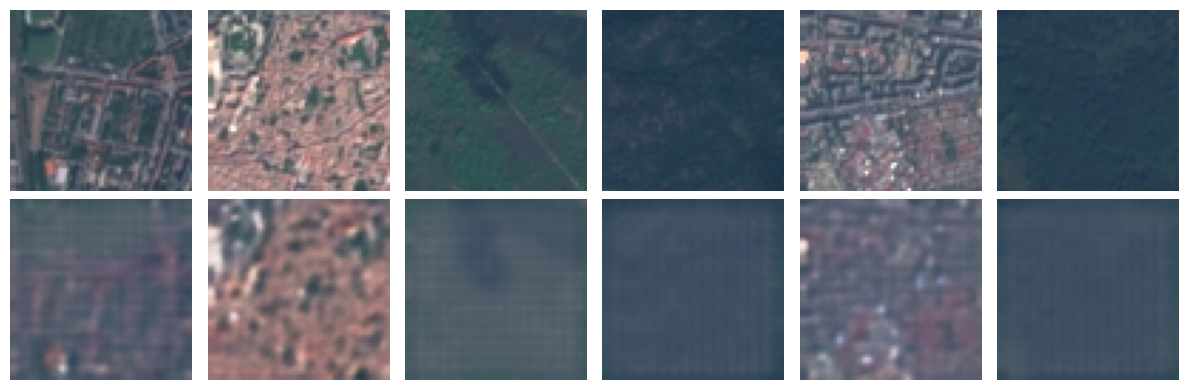

In [21]:
def show_reconstructions_soft(model, loader, n=6):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        _, recon, _, _ = model(imgs)
    imgs = imgs.cpu().permute(0, 2, 3, 1)
    recon = recon.cpu().permute(0, 2, 3, 1)
    imgs = (imgs * 0.5 + 0.5).clamp(0,1)
    recon = (recon * 0.5 + 0.5).clamp(0,1)
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_reconstructions_soft(model_soft, val_loader)


In [22]:
def evaluate_soft(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2, 2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits, _, _, _ = model(x)
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t,p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

acc_all_s, cm_all_s       = evaluate_soft(model_soft, ood_loader)
acc_forest_s, cm_forest_s = evaluate_soft(model_soft, forest_loader)
acc_dense_s, cm_dense_s   = evaluate_soft(model_soft, dense_loader)
acc_medium_s, cm_medium_s = evaluate_soft(model_soft, medium_loader)

print("OOD global acc:", round(acc_all_s,4))
print("Forest acc:", round(acc_forest_s,4))
print("DenseResidential acc:", round(acc_dense_s,4))
print("MediumResidential acc:", round(acc_medium_s,4))
print("CM OOD:\n", cm_all_s.numpy())
print("CM Forest:\n", cm_forest_s.numpy())
print("CM Dense:\n", cm_dense_s.numpy())
print("CM Medium:\n", cm_medium_s.numpy())

OOD global acc: 0.5833
Forest acc: 0.7667
DenseResidential acc: 0.4667
MediumResidential acc: 0.3333
CM OOD:
 [[46 14]
 [36 24]]
CM Forest:
 [[46 14]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [16 14]]
CM Medium:
 [[ 0  0]
 [20 10]]
